# IE 7860 Final Project Winter 2020
# Predicting Arrests in the City of Chicago
## Kayleigh James - kayleighjames@wayne.edu

The goal of this project is to build a model for predicting whether an arrest is made in the city of Chicago from a given police report.  I plan on building multiple classification models (including ANN, SVMs, Logistic Regression, etc.) in order to find the most robust model for this problem.  In addition to this, I will utilize some explainable AI packages discussed in the course in order to see what factors contributed to the arrest (or absence of one).  
By completing this project, not only will we be able to predict whether an arrest is made, we can see why we predict one will or won’t be made.  Through this we can uncover gaps in public safety so we can see how to allocate additional resources or derive other insights regarding what factors contribute to a lack of arrest.


Data was found on the Chicago Data Portal website.  The title of this dataset is Crimes - 2001 to present and it is updated daily. 
https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2
From the description on the website:
“This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present, minus the most recent seven days. Data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system. In order to protect the privacy of crime victims, addresses are shown at the block level only and specific locations are not identified.”
The size of this dataset is 7.09 million rows (observations) and 22 columns (features) where each row represents a reported crime.  The target variable is the ‘Arrest’ column.  

Sources:
- taking a stratified sample of the dataset for a test/train split: 
https://blog.usejournal.com/creating-an-unbiased-test-set-for-your-model-using-stratified-sampling-technique-672b778022d5
- geographical heat map: https://alysivji.github.io/getting-started-with-folium.html
- balancing dataset: https://elitedatascience.com/imbalanced-classes
- dummy variables: https://towardsdatascience.com/the-dummys-guide-to-creating-dummy-variables-f21faddb1d40
- SHAP: https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
## Import Data and Data Cleansing

In [1]:
import pandas as pd

#load the csv file into a pandas data frame
df = pd.read_csv("Crimes_-_2001_to_present.csv")

#only look at data from 2016 to present
df = df.loc[df['Year'] >= 2015]

#remove any duplicates
df = df.drop_duplicates()

#drop any rows with null values in any of the columns
df = df.dropna()

# convert dates to datetime format
df.Date = pd.to_datetime(df.Date, format='%m/%d/%Y %I:%M:%S %p')

# set index to the data column
df.index = pd.DatetimeIndex(df.Date)

#print data types
print(df.dtypes)

#print shape of the data
print(df.shape)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


ID                               int64
Case Number                     object
Date                    datetime64[ns]
Block                           object
IUCR                            object
Primary Type                    object
Description                     object
Location Description            object
Arrest                            bool
Domestic                          bool
Beat                             int64
District                       float64
Ward                           float64
Community Area                 float64
FBI Code                        object
X Coordinate                   float64
Y Coordinate                   float64
Year                             int64
Updated On                      object
Latitude                       float64
Longitude                      float64
Location                        object
dtype: object
(1362199, 22)


In [2]:
df.drop(['Case Number', 'IUCR','Updated On','Year','Ward','Location','FBI Code'], inplace=True, axis=1)

In [3]:
# convert dates to pandas datetime format
df.Date = pd.to_datetime(df.Date, format='%m/%d/%Y %I:%M:%S %p')
# setting the index to be the date will help us a lot later on
df.index = pd.DatetimeIndex(df.Date)

In [4]:
df.head(20)

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Community Area,X Coordinate,Y Coordinate,Latitude,Longitude
Date,,,,,,,,,,,,,,,
2019-04-10 16:37:00,11665567,2019-04-10 16:37:00,102XX S VERNON AVE,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,"SCHOOL, PUBLIC, BUILDING",False,False,511,5.0,49.0,1181051.0,1837225.0,41.708589,-87.612583
2019-04-12 16:08:00,11667963,2019-04-12 16:08:00,032XX N KEELER AVE,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,False,True,1731,17.0,16.0,1147835.0,1921408.0,41.940298,-87.732066
2019-04-19 13:57:00,11667968,2019-04-19 13:57:00,002XX N LARAMIE AVE,OFFENSE INVOLVING CHILDREN,AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,False,True,1532,15.0,25.0,1141669.0,1901165.0,41.884865,-87.755230
2019-04-25 17:20:00,11668309,2019-04-25 17:20:00,108XX S DR MARTIN LUTHER KING JR DR,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,513,5.0,49.0,1180832.0,1833222.0,41.697609,-87.613508
2019-05-13 17:26:00,11692179,2019-05-13 17:26:00,090XX S RACINE AVE,ASSAULT,SIMPLE,STREET,False,False,2222,22.0,73.0,1169908.0,1844927.0,41.729973,-87.653167
2019-05-15 22:30:00,11690557,2019-05-15 22:30:00,026XX W IOWA ST,THEFT,FROM BUILDING,APARTMENT,False,False,1211,12.0,24.0,1158543.0,1905889.0,41.897499,-87.693137
2019-04-27 11:00:00,11694459,2019-04-27 11:00:00,114XX S RACINE AVE,THEFT,$500 AND UNDER,OTHER,False,False,2234,22.0,75.0,1170375.0,1828976.0,41.686191,-87.651918
2019-05-14 10:00:00,11694464,2019-05-14 10:00:00,021XX S ST LOUIS AVE,THEFT,FROM BUILDING,"SCHOOL, PUBLIC, BUILDING",False,False,1024,10.0,29.0,1153429.0,1889475.0,41.852561,-87.712356
2019-05-04 14:00:00,11676085,2019-05-04 14:00:00,001XX E PEARSON ST,THEFT,$500 AND UNDER,HOTEL/MOTEL,False,False,1833,18.0,8.0,1177578.0,1906074.0,41.897596,-87.623218


In [5]:
#map community area numbers to the actual names
areas = {
"1.0": "Rogers Park",
"2.0": "West Ridge",
"3.0": "Uptown",
"4.0": "Lincoln Square",
"5.0": "North Center",
"6.0": "Lakeview",
"7.0": "Lincoln Park",
"8.0": "Near North Side",
"9.0": "Edison Park",
"10.0": "Norwood Park",
"11.0": "Jefferson Park",
"12.0": "Forest Glen",
"13.0": "North Park",
"14.0": "Albany Park",
"15.0": "Portage Park",
"16.0": "Irving Park",
"17.0": "Dunning",
"18.0": "Montclare",
"19.0": "Belmont Cragin",
"20.0": "Hermosa",
"21.0": "Avondale",
"22.0": "Logan Square",
"23.0": "Humboldt Park",
"24.0": "West Town",
"25.0": "Austin",
"26.0": "West Garfield Park",
"27.0": "East Garfield Park",
"28.0": "Near West Side",
"29.0": "North Lawndale",
"30.0": "South Lawndale",
"31.0": "Lower West Side",
"32.0": "Loop",
"33.0": "Near South Side",
"34.0": "Armour Square",
"35.0": "Douglas",
"36.0": "Oakland",
"37.0": "Fuller Park",
"38.0": "Grand Boulevard",
"39.0": "Kenwood",
"40.0": "Washington Park",
"41.0": "Hyde Park",
"42.0": "Woodlawn",
"43.0": "South Shore",
"44.0": "Chatham",
"45.0": "Avalon Park",
"46.0": "South Chicago",
"47.0": "Burnside",
"48.0": "Calumet Heights",
"49.0": "Roseland",
"50.0": "Pullman",
"51.0": "South Deering",
"52.0": "East Side",
"53.0": "West Pullman",
"54.0": "Riverdale",
"55.0": "Hegewisch",
"56.0": "Garfield Ridge",
"57.0": "Archer Heights",
"58.0": "Brighton Park",
"59.0": "McKinley Park",
"60.0": "Bridgeport",
"61.0": "New City",
"62.0": "West Elsdon",
"63.0": "Gage Park",
"64.0": "Clearing",
"65.0": "West Lawn",
"66.0": "Chicago Lawn",
"67.0": "West Englewood",
"68.0": "Englewood",
"69.0": "Greater Grand Crossing",
"70.0": "Ashburn",
"71.0": "Auburn Gresham",
"72.0": "Beverly",
"73.0": "Washington Heights",
"74.0": "Mount Greenwood",
"75.0": "Morgan Park",
"76.0": "O'Hare",
"77.0": "Edgewater"
}
#drop community numbers column and domestic column
df['Community Area'] = df['Community Area'].astype(str)
df['Area Name'] = df['Community Area'].map(areas)
df = df.drop(['Community Area'], axis = 1)

area_to_change = list(df['Area Name'].value_counts()[20:].index)
loc_to_change = list(df['Location Description'].value_counts()[20:].index)
desc_to_change = list(df['Description'].value_counts()[20:].index)

df.loc[df['Area Name'].isin(loc_to_change),df.columns=='Area Name'] = 'OTHER'
df.loc[df['Location Description'].isin(loc_to_change), df.columns=='Location Description'] = 'OTHER'
df.loc[df['Description'].isin(desc_to_change), df.columns=='Description'] = 'OTHER'

df['Area Name'] = pd.Categorical(df['Area Name'])
df['Primary Type'] = pd.Categorical(df['Primary Type'])
df['Location Description'] = pd.Categorical(df['Location Description'])
df['Description'] = pd.Categorical(df['Description'])

In [6]:
df.dtypes

ID                               int64
Date                    datetime64[ns]
Block                           object
Primary Type                  category
Description                   category
Location Description          category
Arrest                            bool
Domestic                          bool
Beat                             int64
District                       float64
X Coordinate                   float64
Y Coordinate                   float64
Latitude                       float64
Longitude                      float64
Area Name                     category
dtype: object

## EDA and Visualizing the Data

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11,5))
df.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month (2015 - Present)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

<Figure size 1100x500 with 1 Axes>

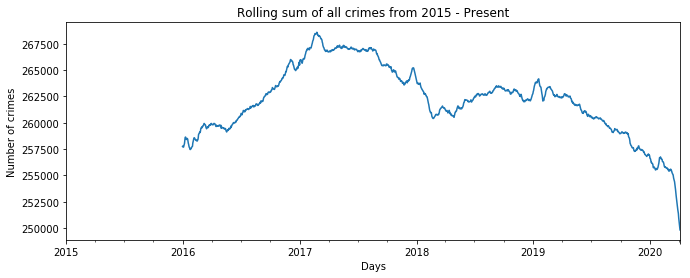

In [8]:
plt.figure(figsize=(11,4))
df.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling sum of all crimes from 2015 - Present')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()

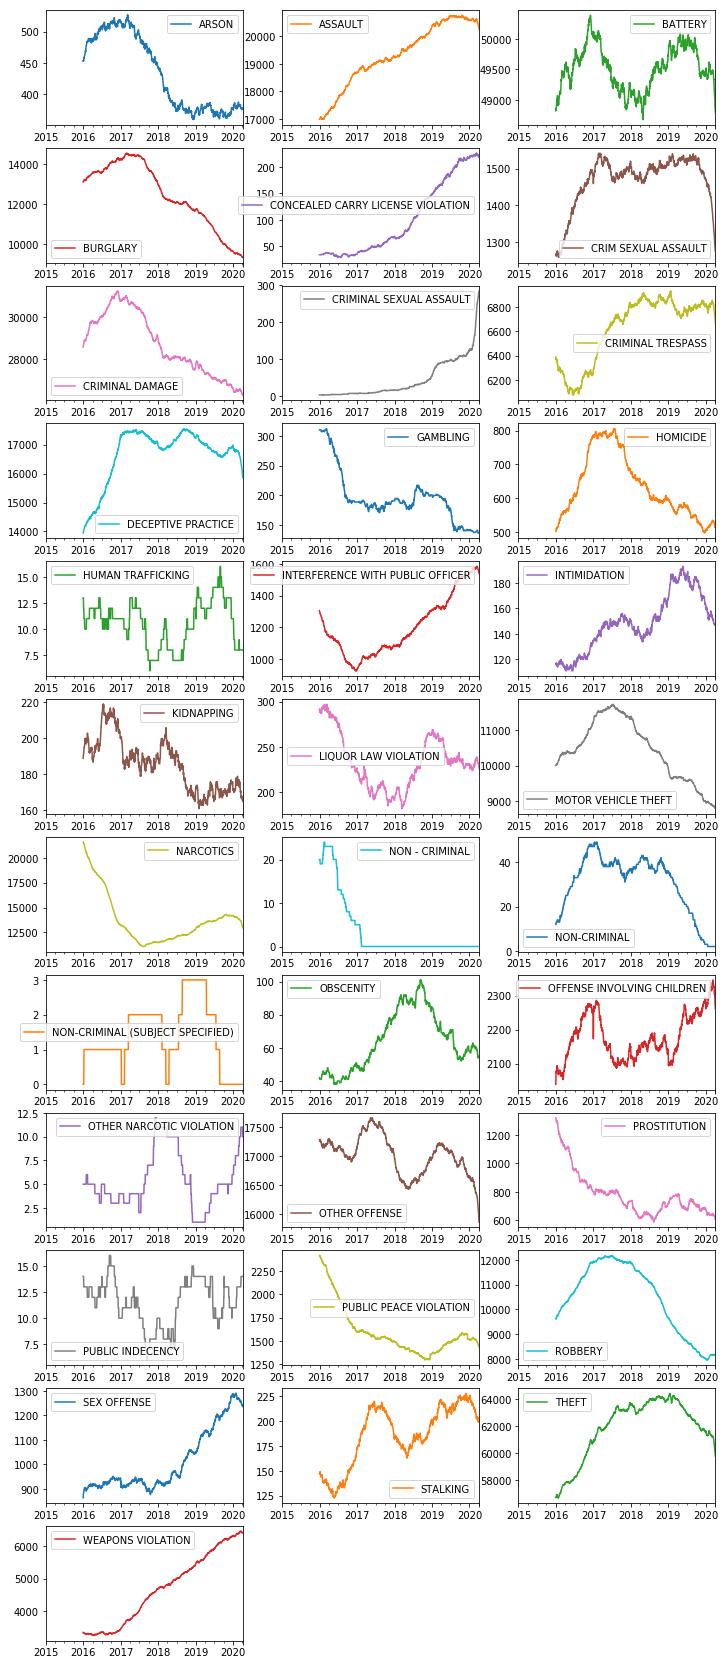

In [9]:
import numpy as np

crimes_count_date = df.pivot_table('ID', aggfunc=np.size, columns='Primary Type', index=df.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

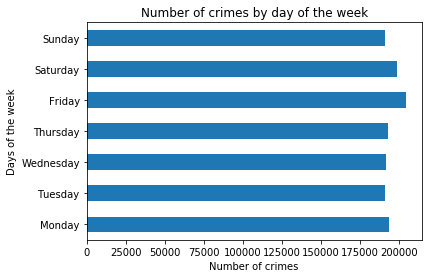

In [10]:
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
df.groupby([df.index.dayofweek]).size().plot(kind='barh')
plt.ylabel('Days of the week')
plt.yticks(np.arange(7), days)
plt.xlabel('Number of crimes')
plt.title('Number of crimes by day of the week')
plt.show()

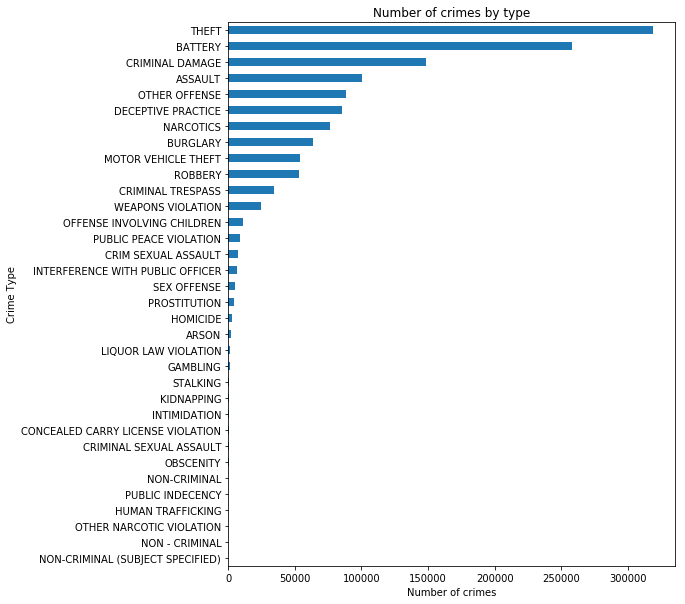

In [11]:
plt.figure(figsize=(8,10))
df.groupby([df['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by type')
plt.ylabel('Crime Type')
plt.xlabel('Number of crimes')
plt.show()

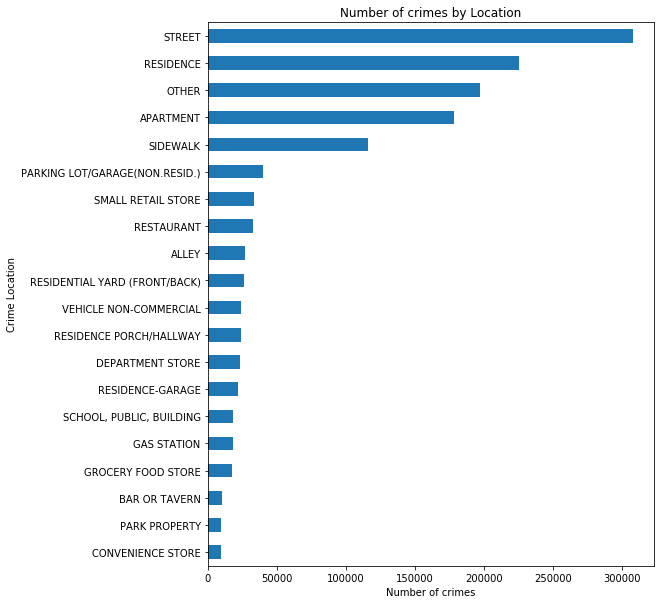

In [12]:
plt.figure(figsize=(8,10))
df.groupby([df['Location Description']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by Location')
plt.ylabel('Crime Location')
plt.xlabel('Number of crimes')
plt.show()

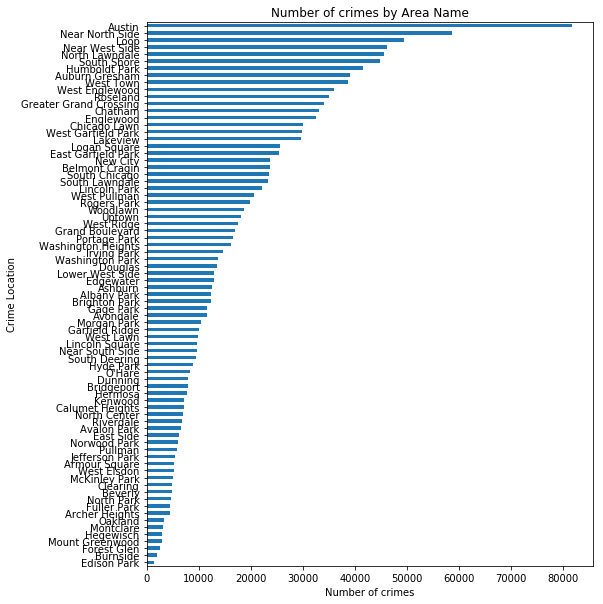

In [13]:
plt.figure(figsize=(8,10))
df.groupby([df['Area Name']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by Area Name')
plt.ylabel('Crime Location')
plt.xlabel('Number of crimes')
plt.show()

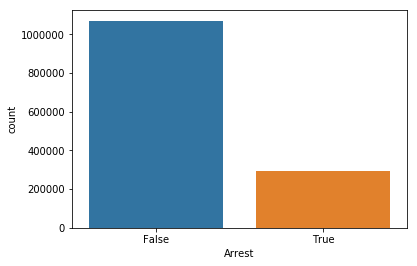

In [14]:
import seaborn as sns

ax = sns.countplot(x="Arrest", data=df)

## Balancing the Dataset

In [15]:
print(df.Arrest.value_counts())

from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.Arrest==0]
df_minority = df[df.Arrest==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=291552,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
print("Arrest Value Counts after Down Sampling the Majority Class: \n")
print(df_downsampled.Arrest.value_counts())

False    1070647
True      291552
Name: Arrest, dtype: int64
Arrest Value Counts after Down Sampling the Majority Class: 

True     291552
False    291552
Name: Arrest, dtype: int64


## Scaling Numerical Features Data, Creating Dummy Features for Categorical Features, and Encoding the Output Variable

In [16]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

#separate features from the target variable
X = df_downsampled.drop(['ID','Block'], axis=1)
y = df_downsampled['Arrest']

#scaling the numerical features
num_cols = ['Beat','District','X Coordinate','Y Coordinate', 'Latitude','Longitude']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

#encoding the output variable
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

#get dummy variables for the categorical features
dummy = pd.get_dummies(X['Primary Type'])
X = pd.concat([X, dummy], axis=1)

dummy = pd.get_dummies(X['Description'])
X = pd.concat([X, dummy], axis=1)

dummy = pd.get_dummies(X['Location Description'])
X = pd.concat([X, dummy], axis=1)

dummy = pd.get_dummies(X['Area Name'])
X = pd.concat([X, dummy], axis=1)

dummy = pd.get_dummies(X['Domestic'])
X = pd.concat([X, dummy], axis=1)

X = X.drop(['Primary Type', 'Description', 'Location Description', 'Area Name', 'Domestic'], axis=1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [17]:
X.dtypes

Date                                 datetime64[ns]
Arrest                                         bool
Beat                                        float64
District                                    float64
X Coordinate                                float64
Y Coordinate                                float64
Latitude                                    float64
Longitude                                   float64
ARSON                                         uint8
ASSAULT                                       uint8
BATTERY                                       uint8
BURGLARY                                      uint8
CONCEALED CARRY LICENSE VIOLATION             uint8
CRIM SEXUAL ASSAULT                           uint8
CRIMINAL DAMAGE                               uint8
CRIMINAL SEXUAL ASSAULT                       uint8
CRIMINAL TRESPASS                             uint8
DECEPTIVE PRACTICE                            uint8
GAMBLING                                      uint8
HOMICIDE    

In [18]:
X.shape

(583104, 162)

## Logistic Regression

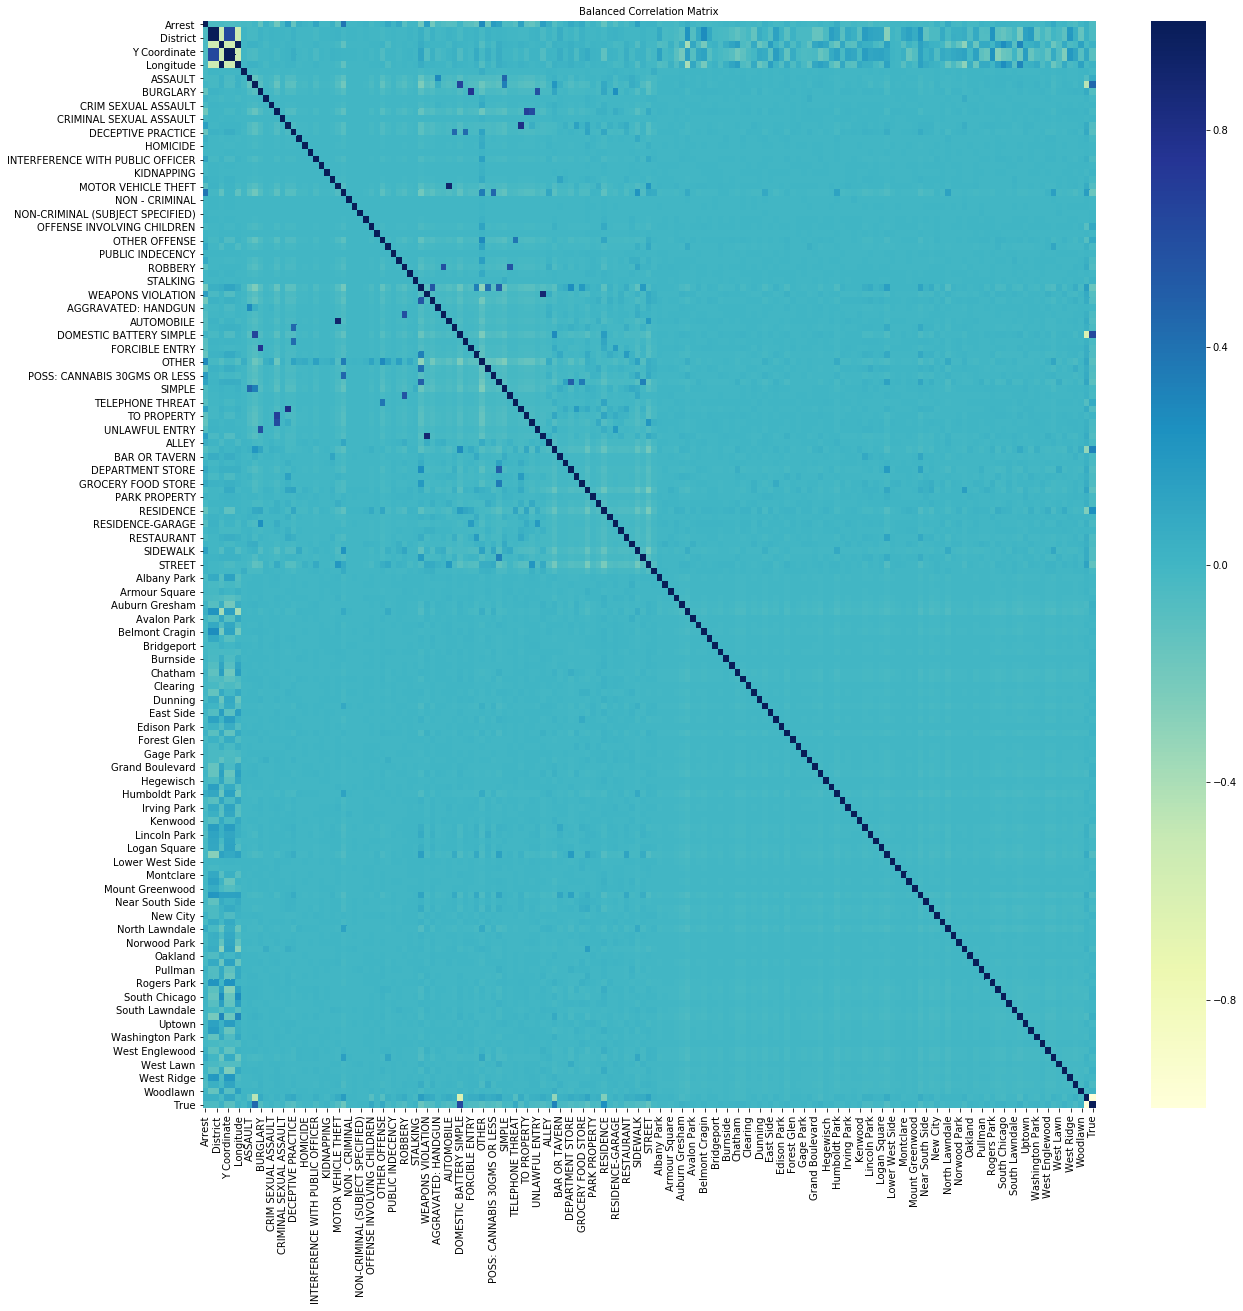

In [19]:
#Correlation with output variable
cor = X.corr()
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,20))         
# Imbalanced DataFrame Correlation
sns.heatmap(cor, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Balanced Correlation Matrix", fontsize=10)
plt.show()

In [20]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = X.drop(["Date"], axis=1)
X = X.drop(["Arrest"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
classifier = LogisticRegression(random_state=0, penalty='l2', solver='liblinear')
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

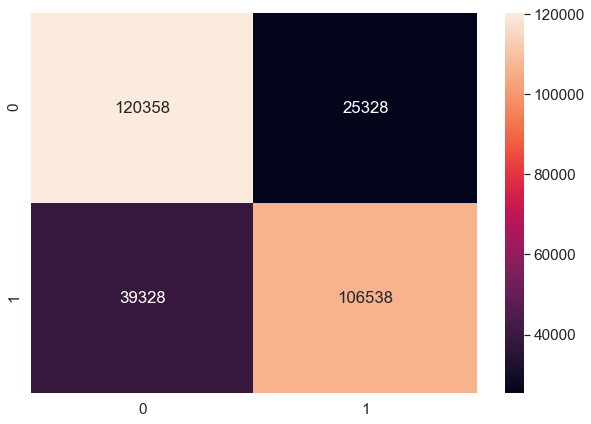

In [21]:
from sklearn.metrics import confusion_matrix
#Predicting Test set
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='g')

In [22]:
from sklearn.metrics import classification_report
print("Baseline LogReg (All Features) Classification Report")
print(classification_report(y_test, y_pred))

Baseline LogReg (All Features) Classification Report
              precision    recall  f1-score   support

           0       0.75      0.83      0.79    145686
           1       0.81      0.73      0.77    145866

   micro avg       0.78      0.78      0.78    291552
   macro avg       0.78      0.78      0.78    291552
weighted avg       0.78      0.78      0.78    291552



In [23]:
print('Accuracy of logistic regression classifier on training set: {:.2f}'.format(classifier.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on training set: 0.78
Accuracy of logistic regression classifier on test set: 0.78


In [24]:
#Feature selection 
#Recursive feature elimination w/ Cross Validation
from sklearn.feature_selection import RFECV

#Select best feature 
rfecv = RFECV(classifier, verbose=1, step=20, cv=5)
rfecv= rfecv.fit(X_train, y_train)

#Summarize the selection of the attributes
print(rfecv.support_)
print(rfecv.ranking_)
X_train.columns[rfecv.support_]

Fitting estimator with 160 features.
Fitting estimator with 140 features.
Fitting estimator with 120 features.
Fitting estimator with 100 features.
Fitting estimator with 80 features.
Fitting estimator with 60 features.
Fitting estimator with 40 features.
Fitting estimator with 20 features.
Fitting estimator with 160 features.
Fitting estimator with 140 features.
Fitting estimator with 120 features.
Fitting estimator with 100 features.
Fitting estimator with 80 features.
Fitting estimator with 60 features.
Fitting estimator with 40 features.
Fitting estimator with 20 features.
Fitting estimator with 160 features.
Fitting estimator with 140 features.
Fitting estimator with 120 features.
Fitting estimator with 100 features.
Fitting estimator with 80 features.
Fitting estimator with 60 features.
Fitting estimator with 40 features.
Fitting estimator with 20 features.
Fitting estimator with 160 features.
Fitting estimator with 140 features.
Fitting estimator with 120 features.
Fitting estim

Index(['ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY',
       'CONCEALED CARRY LICENSE VIOLATION', 'CRIM SEXUAL ASSAULT',
       'CRIMINAL DAMAGE', 'CRIMINAL SEXUAL ASSAULT', 'CRIMINAL TRESPASS',
       'DECEPTIVE PRACTICE', 'GAMBLING', 'HOMICIDE', 'HUMAN TRAFFICKING',
       'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION', 'KIDNAPPING',
       'LIQUOR LAW VIOLATION', 'MOTOR VEHICLE THEFT', 'NARCOTICS',
       'NON - CRIMINAL', 'NON-CRIMINAL', 'OBSCENITY',
       'OFFENSE INVOLVING CHILDREN', 'OTHER NARCOTIC VIOLATION',
       'OTHER OFFENSE', 'PROSTITUTION', 'PUBLIC INDECENCY',
       'PUBLIC PEACE VIOLATION', 'ROBBERY', 'SEX OFFENSE', 'STALKING', 'THEFT',
       '$500 AND UNDER', 'AGGRAVATED: HANDGUN', 'ARMED: HANDGUN',
       'CREDIT CARD FRAUD', 'FINANCIAL IDENTITY THEFT OVER $ 300',
       'FROM BUILDING', 'OTHER', 'OVER $500', 'POSS: CANNABIS 30GMS OR LESS',
       'RETAIL THEFT', 'SIMPLE', 'TELEPHONE THREAT', 'TO LAND', 'TO VEHICLE',
       'UNLAWFUL POSS OF HANDGUN', 'APARTMENT',

In [25]:
classifier_rfe = LogisticRegression(random_state=0, penalty='l2', solver='liblinear')
classifier_rfe.fit(X_train[X_train.columns[rfecv.support_]], y_train)
# Predicting Test Set
y_pred = classifier_rfe.predict(X_test[X_train.columns[rfecv.support_]])
print("LogReg (With RFECV) Classification Report")
print(classification_report(y_test, y_pred))
print('Accuracy of logistic regression classifier on training set: {:.2f}'.format(classifier_rfe.score(X_train[X_train.columns[rfecv.support_]], y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier_rfe.score(X_test[X_test.columns[rfecv.support_]], y_test)))

LogReg (With RFECV) Classification Report
              precision    recall  f1-score   support

           0       0.74      0.85      0.79    145686
           1       0.83      0.71      0.76    145866

   micro avg       0.78      0.78      0.78    291552
   macro avg       0.79      0.78      0.78    291552
weighted avg       0.79      0.78      0.78    291552

Accuracy of logistic regression classifier on training set: 0.78
Accuracy of logistic regression classifier on test set: 0.78


## Artificial Neural Network

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, train_size=0.1, random_state = 0)
print("Number of training points: ",X_train.shape)
print("Number of testing points: ",X_test.shape)

Number of training points:  (58310, 160)
Number of testing points:  (58311, 160)


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 58310 samples, validate on 58311 samples
Epoch 1/20
58310/58310 [==============================] - 2s 36us/step - loss: 0.5941 - acc: 0.6610 - val_loss: 0.4635 - val_acc: 0.7686
Epoch 2/20
58310/58310 [==============================] - 2s 29us/step - loss: 0.4769 - acc: 0.7605 - val_loss: 0.4412 - val_acc: 0.7729
Epoch 3/20
58310/58310 [==============================] - 2s 29us/step - loss: 0.4587 - acc: 0.7695 - val_loss: 0.4343 - val_acc: 0.7751
Epoch 4/20
58310/58310 [==============================] - 2s 29us/step - loss: 0.4486 - acc: 0.7741 - val_loss: 0.4304 - val_acc: 0.7778
Epoch 5/20
58310/58310 [==============================] - 2s 29us/step - loss: 0.4426 - acc: 0.7760 - val_loss: 0.4286 - val_acc: 0.7776
Epoch 6/20
58310/58310 [======

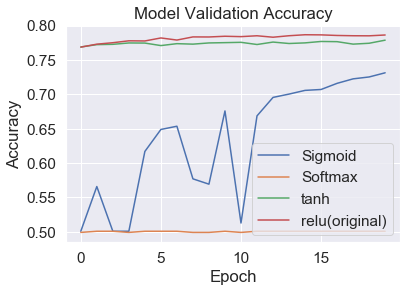

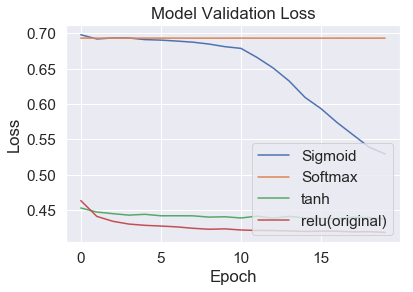

In [27]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD


#declare an artifical neural network
mlp = Sequential()

#Specify Network Parameters
mlp.add(Dense(64, input_dim=160, activation='relu'))
mlp.add(Dropout(0.5))
mlp.add(Dense(64, activation='relu'))
mlp.add(Dropout(0.5))

#The output layer must be a single node and the activation function for the final layer must be a sigmoid
mlp.add(Dense(1, activation='sigmoid'))

#Use a stoichiastic gradient descent optimizer with learning rate of 0.01 and momentum of 0.9
opt = SGD(lr=0.01, momentum=0.9)

#Build the netwrok
mlp.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

#Use the training set to train the network
history = mlp.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=20,
          batch_size=128)
#declare an artifical neural network
mlp_sig = Sequential()
mlp_soft = Sequential()
mlp_tanh= Sequential()

#Specify Network Parameters
mlp_sig.add(Dense(64, input_dim=160, activation='sigmoid'))
mlp_sig.add(Dropout(0.5))
mlp_sig.add(Dense(64, activation='sigmoid'))
mlp_sig.add(Dropout(0.5))

mlp_soft.add(Dense(64, input_dim=160, activation='softmax'))
mlp_soft.add(Dropout(0.5))
mlp_soft.add(Dense(64, activation='softmax'))
mlp_soft.add(Dropout(0.5))

mlp_tanh.add(Dense(64, input_dim=160, activation='tanh'))
mlp_tanh.add(Dropout(0.5))
mlp_tanh.add(Dense(64, activation='tanh'))
mlp_tanh.add(Dropout(0.5))

#The output layer must be a single node and the activation function for the final layer must be a sigmoid
mlp_sig.add(Dense(1, activation='sigmoid'))
mlp_soft.add(Dense(1, activation='sigmoid'))
mlp_tanh.add(Dense(1, activation='sigmoid'))

#Use a stoichiastic gradient descent optimizer with learning rate of 0.01 and momentum of 0.9
opt = SGD(lr=0.01, momentum=0.9)

#Build the netwrok
mlp_sig.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
mlp_soft.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
mlp_tanh.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

#Use the training set to train the network
history_sig = mlp_sig.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=20,
          batch_size=128)
history_soft = mlp_soft.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=20,
          batch_size=128)
history_tanh = mlp_tanh.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=20,
          batch_size=128)

# Plot Validation accuracy values
plt.plot(history_sig.history['val_acc'])
plt.plot(history_soft.history['val_acc'])
plt.plot(history_tanh.history['val_acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Sigmoid', 'Softmax', 'tanh', 'relu(original)'], loc='lower right')
plt.show()

# Plot Validation loss values
plt.plot(history_sig.history['val_loss'])
plt.plot(history_soft.history['val_loss'])
plt.plot(history_tanh.history['val_loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Sigmoid', 'Softmax', 'tanh', 'relu(original)'], loc='lower right')
plt.show()

MLP (ReLu Activation) Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.81      0.79     29106
           1       0.80      0.76      0.78     29205

   micro avg       0.79      0.79      0.79     58311
   macro avg       0.79      0.79      0.79     58311
weighted avg       0.79      0.79      0.79     58311



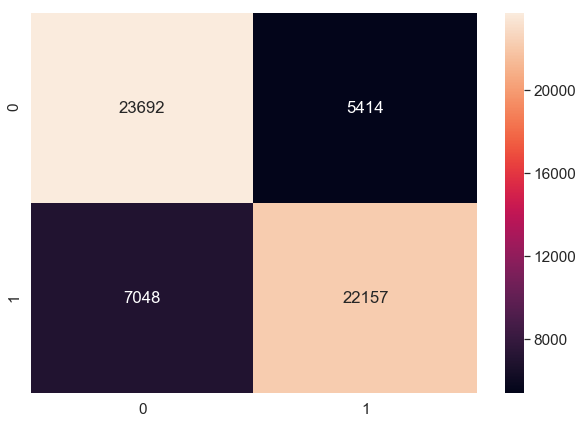

In [28]:
#Calculate y predicted of the test set
y_pred = mlp.predict(X_test)
y_pred = (y_pred > 0.5)

print("MLP (ReLu Activation) Classification Report: ")
print(classification_report(y_test, y_pred))

#Build a confusion matrix comparing the true values of y and the predicted values of y
matrix = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix as a seaborn heatmap
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, fmt='g')

MLP (tanh Activation) Classification Report: 
              precision    recall  f1-score   support

           0       0.76      0.82      0.79     29106
           1       0.80      0.74      0.77     29205

   micro avg       0.78      0.78      0.78     58311
   macro avg       0.78      0.78      0.78     58311
weighted avg       0.78      0.78      0.78     58311



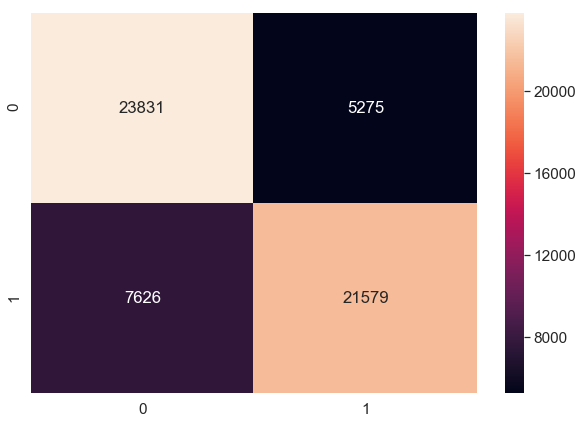

In [29]:
#Calculate y predicted of the test set
y_pred = mlp_tanh.predict(X_test)
y_pred = (y_pred > 0.5)

#Build a confusion matrix comparing the true values of y and the predicted values of y
print("MLP (tanh Activation) Classification Report: ")
print(classification_report(y_test, y_pred))

matrix = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix as a seaborn heatmap
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, fmt='g')

Train on 58310 samples, validate on 58311 samples
Epoch 1/20
58310/58310 [==============================] - 3s 46us/step - loss: 0.6376 - acc: 0.6128 - val_loss: 0.4844 - val_acc: 0.7593
Epoch 2/20
58310/58310 [==============================] - 2s 34us/step - loss: 0.4945 - acc: 0.7544 - val_loss: 0.4477 - val_acc: 0.7735
Epoch 3/20
58310/58310 [==============================] - 2s 35us/step - loss: 0.4670 - acc: 0.7666 - val_loss: 0.4365 - val_acc: 0.7765
Epoch 4/20
58310/58310 [==============================] - 2s 34us/step - loss: 0.4566 - acc: 0.7721 - val_loss: 0.4330 - val_acc: 0.7755
Epoch 5/20
58310/58310 [==============================] - 2s 34us/step - loss: 0.4472 - acc: 0.7756 - val_loss: 0.4325 - val_acc: 0.7733
Epoch 6/20
58310/58310 [==============================] - 2s 35us/step - loss: 0.4458 - acc: 0.7758 - val_loss: 0.4273 - val_acc: 0.7816
Epoch 7/20
58310/58310 [==============================] - 2s 34us/step - loss: 0.4417 - acc: 0.7785 - val_loss: 0.4268 - val_acc

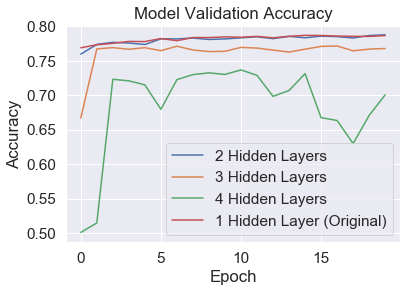

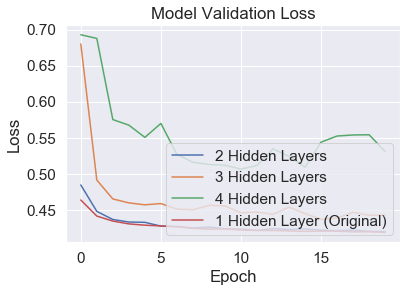

In [30]:
#declare an artifical neural network
mlp_2_hidden = Sequential()
mlp_3_hidden = Sequential()
mlp_4_hidden = Sequential()

#Specify Network Parameters
mlp_2_hidden.add(Dense(64, input_dim=160, activation='relu'))
mlp_2_hidden.add(Dropout(0.5))
mlp_2_hidden.add(Dense(64, activation='relu'))
mlp_2_hidden.add(Dropout(0.5))
mlp_2_hidden.add(Dense(64, activation='relu'))
mlp_2_hidden.add(Dropout(0.5))

mlp_3_hidden.add(Dense(64, input_dim=160, activation='relu'))
mlp_3_hidden.add(Dropout(0.5))
mlp_3_hidden.add(Dense(64, activation='relu'))
mlp_3_hidden.add(Dropout(0.5))
mlp_3_hidden.add(Dense(64, activation='relu'))
mlp_3_hidden.add(Dropout(0.5))
mlp_3_hidden.add(Dense(64, activation='relu'))
mlp_3_hidden.add(Dropout(0.5))
mlp_3_hidden.add(Dense(64, activation='relu'))
mlp_3_hidden.add(Dropout(0.5))

mlp_4_hidden.add(Dense(64, input_dim=160, activation='relu'))
mlp_4_hidden.add(Dropout(0.5))
mlp_4_hidden.add(Dense(64, activation='relu'))
mlp_4_hidden.add(Dropout(0.5))
mlp_4_hidden.add(Dense(64, activation='relu'))
mlp_4_hidden.add(Dropout(0.5))
mlp_4_hidden.add(Dense(64, activation='relu'))
mlp_4_hidden.add(Dropout(0.5))
mlp_4_hidden.add(Dense(64, activation='relu'))
mlp_4_hidden.add(Dropout(0.5))
mlp_4_hidden.add(Dense(64, activation='relu'))
mlp_4_hidden.add(Dropout(0.5))

#The output layer must be a single node and the activation function for the final layer must be a sigmoid
mlp_2_hidden.add(Dense(1, activation='sigmoid'))
mlp_3_hidden.add(Dense(1, activation='sigmoid'))
mlp_4_hidden.add(Dense(1, activation='sigmoid'))

#Use a stoichiastic gradient descent optimizer with learning rate of 0.01 and momentum of 0.9
opt = SGD(lr=0.01, momentum=0.9)

#Build the netwrok
mlp_2_hidden.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
mlp_3_hidden.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
mlp_4_hidden.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

#Use the training set to train the network
history2 = mlp_2_hidden.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=20,
          batch_size=128)
history3 = mlp_3_hidden.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=20,
          batch_size=128)
history4 = mlp_4_hidden.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=20,
          batch_size=128)

# Plot Validation accuracy values
plt.plot(history2.history['val_acc'])
plt.plot(history3.history['val_acc'])
plt.plot(history4.history['val_acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['2 Hidden Layers', '3 Hidden Layers', '4 Hidden Layers', '1 Hidden Layer (Original)'], loc='lower right')
plt.show()

# Plot Validation loss values
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_loss'])
plt.plot(history4.history['val_loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['2 Hidden Layers', '3 Hidden Layers', '4 Hidden Layers', '1 Hidden Layer (Original)'], loc='lower right')
plt.show()

MLP (ReLu Activation) Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.82      0.79     29106
           1       0.81      0.76      0.78     29205

   micro avg       0.79      0.79      0.79     58311
   macro avg       0.79      0.79      0.79     58311
weighted avg       0.79      0.79      0.79     58311



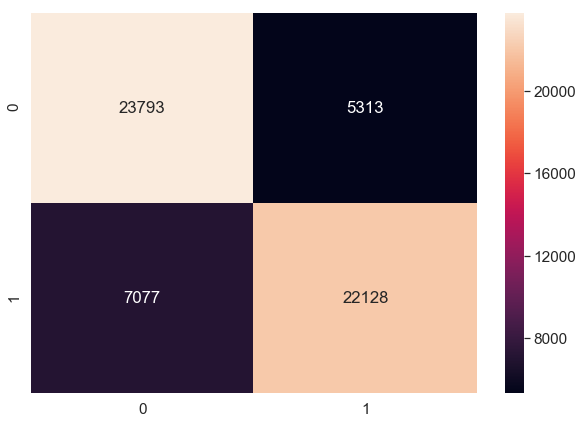

In [31]:
#Calculate y predicted of the test set
y_pred = mlp_2_hidden.predict(X_test)
y_pred = (y_pred > 0.5)

print("MLP (ReLu Activation) Classification Report: ")
print(classification_report(y_test, y_pred))

#Build a confusion matrix comparing the true values of y and the predicted values of y
matrix = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix as a seaborn heatmap
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, fmt='g')

MLP (ReLu Activation) Classification Report: 
              precision    recall  f1-score   support

           0       0.69      0.96      0.80     29106
           1       0.93      0.58      0.71     29205

   micro avg       0.77      0.77      0.77     58311
   macro avg       0.81      0.77      0.76     58311
weighted avg       0.81      0.77      0.76     58311



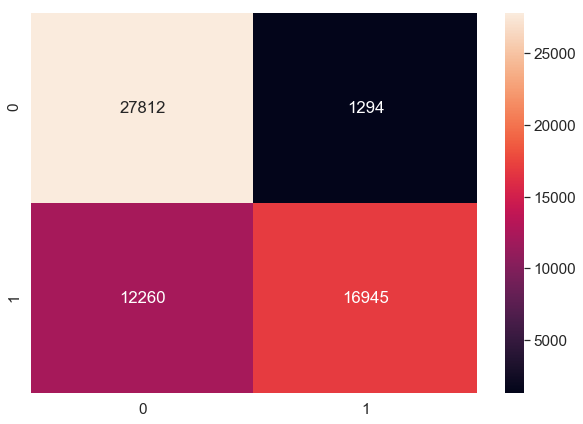

In [32]:
#Calculate y predicted of the test set
y_pred = mlp_3_hidden.predict(X_test)
y_pred = (y_pred > 0.5)

print("MLP (ReLu Activation) Classification Report: ")
print(classification_report(y_test, y_pred))

#Build a confusion matrix comparing the true values of y and the predicted values of y
matrix = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix as a seaborn heatmap
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, fmt='g')

MLP (ReLu Activation) Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.45      0.60     29106
           1       0.63      0.95      0.76     29205

   micro avg       0.70      0.70      0.70     58311
   macro avg       0.77      0.70      0.68     58311
weighted avg       0.77      0.70      0.68     58311



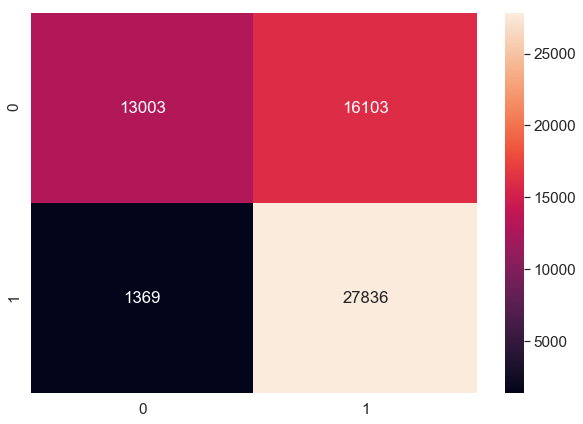

In [33]:
#Calculate y predicted of the test set
y_pred = mlp_4_hidden.predict(X_test)
y_pred = (y_pred > 0.5)

print("MLP (ReLu Activation) Classification Report: ")
print(classification_report(y_test, y_pred))

#Build a confusion matrix comparing the true values of y and the predicted values of y
matrix = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix as a seaborn heatmap
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, fmt='g')

## Support Vector Machines

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01, train_size=0.01, random_state = 0)
print("Number of training points: ",X_train.shape)
print("Number of testing points: ",X_test.shape)

Number of training points:  (5831, 160)
Number of testing points:  (5832, 160)


In [35]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, tol=1e-5, max_iter=10000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      2838
           1       0.79      0.75      0.77      2994

   micro avg       0.77      0.77      0.77      5832
   macro avg       0.77      0.77      0.77      5832
weighted avg       0.77      0.77      0.77      5832



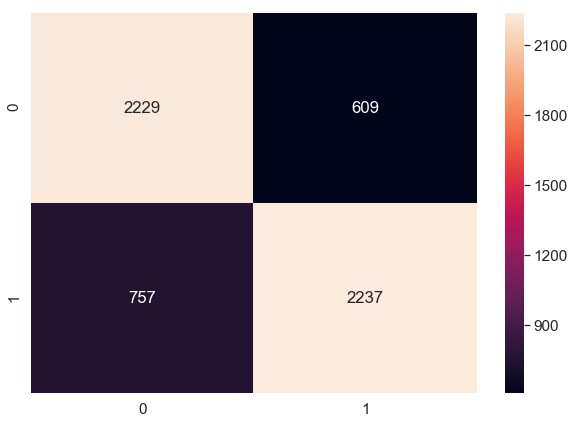

In [36]:
#Build a confusion matrix comparing the true values of y and the predicted values of y
matrix = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix as a seaborn heatmap
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, fmt='g')

In [37]:
from sklearn.decomposition import PCA

pca = PCA(.95)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

clf = LinearSVC(random_state=0, tol=1e-5, max_iter=10000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.78      0.77      2838
           1       0.79      0.75      0.77      2994

   micro avg       0.77      0.77      0.77      5832
   macro avg       0.77      0.77      0.77      5832
weighted avg       0.77      0.77      0.77      5832



## Decision Tree

In [38]:
from sklearn import tree

from sklearn.preprocessing import StandardScaler, LabelEncoder

#separate features from the target variable
X = df_downsampled.drop(['ID','Block'], axis=1)
y = df_downsampled['Arrest']

#scaling the numerical features
num_cols = ['Beat','District','X Coordinate','Y Coordinate', 'Latitude','Longitude']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

#encoding the output variable
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

#get dummy variables for the categorical features
dummy = pd.get_dummies(X['Primary Type'])
X = pd.concat([X, dummy], axis=1)

dummy = pd.get_dummies(X['Description'])
X = pd.concat([X, dummy], axis=1)

dummy = pd.get_dummies(X['Location Description'])
X = pd.concat([X, dummy], axis=1)

dummy = pd.get_dummies(X['Area Name'])
X = pd.concat([X, dummy], axis=1)

dummy = pd.get_dummies(X['Domestic'])
X = pd.concat([X, dummy], axis=1)

X = X.drop(['Arrest','Date','Primary Type', 'Description', 'Location Description', 'Area Name', 'Domestic'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, train_size=0.1, random_state = 0)
print("Number of training points: ",X_train.shape)
print("Number of testing points: ",X_test.shape)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Number of training points:  (58310, 160)
Number of testing points:  (58311, 160)
              precision    recall  f1-score   support

           0       0.74      0.74      0.74     29106
           1       0.74      0.74      0.74     29205

   micro avg       0.74      0.74      0.74     58311
   macro avg       0.74      0.74      0.74     58311
weighted avg       0.74      0.74      0.74     58311



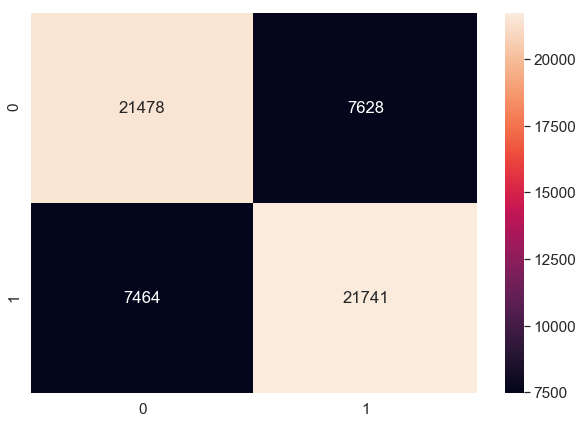

In [39]:
#Build a confusion matrix comparing the true values of y and the predicted values of y
matrix = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix as a seaborn heatmap
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, fmt='g')

In [40]:
# Make an instance of the Model
pca = PCA(.95)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73     29106
           1       0.73      0.74      0.73     29205

   micro avg       0.73      0.73      0.73     58311
   macro avg       0.73      0.73      0.73     58311
weighted avg       0.73      0.73      0.73     58311



In [41]:
print(pca.explained_variance_ratio_)

[0.42854604 0.12085257 0.07921862 0.04101234 0.02962037 0.02046988
 0.01773102 0.01489677 0.01339584 0.0122043  0.01081924 0.00974449
 0.00869926 0.00809889 0.00705644 0.00618844 0.00571444 0.00558936
 0.00554766 0.00487435 0.00463602 0.00453593 0.00403503 0.00389264
 0.00387448 0.00369119 0.00352436 0.00336304 0.00330184 0.0031854
 0.00307275 0.0029797  0.00294415 0.00276665 0.00271564 0.00262275
 0.00258781 0.0025084  0.00246966 0.00244301 0.00234737 0.00223298
 0.00216025 0.00213324 0.00209266 0.00203098 0.00194014 0.00190269
 0.00188292 0.00180523 0.00178342 0.00175409 0.00173471 0.0016528
 0.00163063 0.00160818 0.00155064 0.00154416 0.00147728]


## Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, train_size=0.1, random_state = 0)
print("Number of training points: ",X_train.shape)
print("Number of testing points: ",X_test.shape)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
RandomForestClassifier(max_depth=2, random_state=0)
print(clf.feature_importances_)

Number of training points:  (58310, 160)
Number of testing points:  (58311, 160)


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.00000000e+00 3.77960664e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.40573729e-02 0.00000000e+00 8.56481088e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.59797442e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80300076e-02
 0.00000000e+00 0.00000000e+00 8.65394427e-02 8.04687262e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.47918847e-02
 0.00000000e+00 5.96384700e-03 0.00000000e+00 5.93710381e-02
 5.22443052e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.27623144e-02 2.75025980e-02 6.71603224e-02 0.00000000e+00
 5.67000924e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [43]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.95      0.75     29106
           1       0.89      0.43      0.58     29205

   micro avg       0.69      0.69      0.69     58311
   macro avg       0.76      0.69      0.67     58311
weighted avg       0.76      0.69      0.67     58311



In [44]:
pca = PCA(.95)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
RandomForestClassifier(max_depth=2, random_state=0)
print(clf.feature_importances_)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.         0.         0.         0.17883929 0.28253499 0.
 0.         0.04267991 0.         0.         0.01471893 0.02624648
 0.03366094 0.         0.03368497 0.01287402 0.         0.
 0.19696061 0.00045648 0.         0.10038313 0.         0.03383957
 0.01607195 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.02704872 0.         0.
 0.         0.         0.         0.         0.        ]
              precision    recall  f1-score   support

           0       0.70      0.72      0.71     29106
           1       0.72      0.70      0.71     29205

   micro avg       0.71      0.71      0.71     58311
   macro avg       0.71      0.71      0.71     58311
weighted avg       0.71      0.71      0.71     58311



In [45]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
RandomForestClassifier(max_depth=2, random_state=0)
print(clf.feature_importances_)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.00198397 0.00328977 0.00184505 0.10646468 0.1052545  0.00949719
 0.04587123 0.0595925  0.01996327 0.01128137 0.02321686 0.02129508
 0.03888606 0.03836957 0.06271494 0.05610406 0.00476914 0.00602126
 0.06032    0.03112323 0.02328655 0.06959433 0.02179025 0.01831089
 0.01615304 0.01176812 0.00371772 0.00276192 0.00558445 0.00230773
 0.00350451 0.00192413 0.0030794  0.00296411 0.00181332 0.00493346
 0.00155402 0.00289942 0.00295665 0.00151677 0.00264962 0.00559104
 0.00226702 0.00131776 0.0045907  0.00291799 0.00332321 0.00613873
 0.00222717 0.00207595 0.00962111 0.02045575 0.00459912 0.00209151
 0.00395617 0.00176827 0.00827946 0.00215805 0.00368687]
              precision    recall  f1-score   support

           0       0.76      0.82      0.79     29106
           1       0.81      0.74      0.77     29205

   micro avg       0.78      0.78      0.78     58311
   macro avg       0.78      0.78      0.78     58311
weighted avg       0.78      0.78      0.78     58311



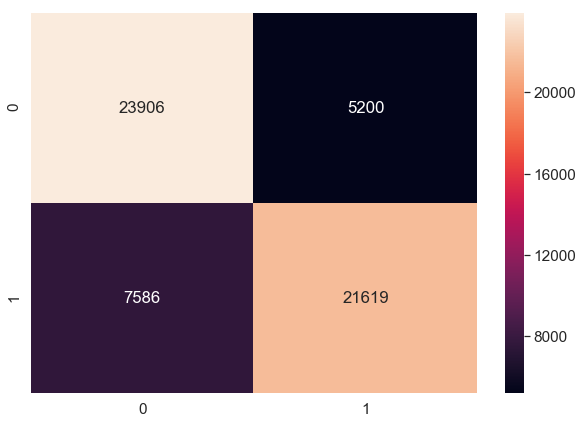

In [46]:
#Build a confusion matrix comparing the true values of y and the predicted values of y
matrix = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix as a seaborn heatmap
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, fmt='g')

## Explainable AI Using SHAP - Explaining the SVM Model

In [88]:
import shap
shap.initjs() 

In [74]:
from sklearn.svm import LinearSVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01, train_size=0.01, random_state = 0)
clf = LinearSVC(random_state=0, tol=1e-5, max_iter=10000)
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

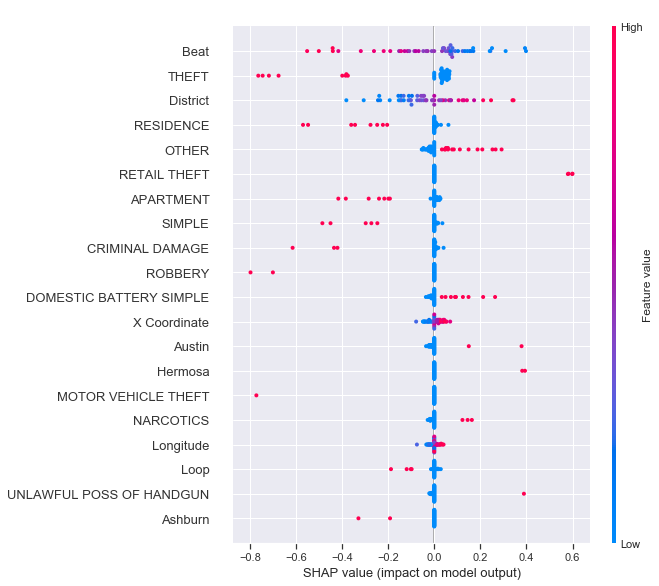

In [87]:
X_train_summary = shap.kmeans(X_train, 50)
explainer = shap.KernelExplainer(clf.predict, X_train_summary)
shap_values = explainer.shap_values(X_test.iloc[:50])
shap.summary_plot(shap_values, X_test.iloc[:50])

In [89]:
shap.force_plot(explainer.expected_value, shap_values[10,:], X_test.iloc[10,:])

In [91]:
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[:50])